In [1]:
# making imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# check if gpu is available
torch.cuda.is_available()

True

# step1: define the model architecture

In [3]:
# use torch.nn module to define a model with 
# 1) two convolutional layers with output channel 16, 32 each with kernel 3 and stride 1
# 2) relu activation after each convolutional layer
# 3) max pooling with kernel 2
# 4) a dropout layer with rate 10%
# 5) a flattern layer
# 6) a dense layer with 64 neurons
# 7) a relu activation
# 8) a drop out layer with rate 25%
# 9) a dense layer with 10 neurons
# 10) use softmax activation

class myConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1) # can we choose what features?
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.do1 = nn.Dropout2d(0.1)
        self.do2 = nn.Dropout(0.25)
        self.lf1 = nn.Linear(4608, 64) # have to calculate the input size by hand?
        self.lf2 = nn.Linear(64,10)
    
    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.do1(x)
        x = torch.flatten(x,1) # not flatten the batch channel?
        x = self.lf1(x)
        x = F.relu(x)
        x = self.do2(x)
        x = self.lf2(x)
        op = F.log_softmax(x,1) # have to exclude last channel for all functions?
        return op              # don't need to specify the number of output classes?


        


In [4]:
# implementing VGG model from scratch
class myVGG(nn.Module):
    def __init__(self):
        super(myVGG,self).__init__()
        self.conv11=nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.conv12=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.conv21=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.conv22=nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.dropout2=nn.Dropout2d(p=0.1)
        self.conv31=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.conv41=nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1)
        self.dense1=nn.Linear(in_features=12544,out_features=64)
        self.dropout3=nn.Dropout(p=0.3)
        self.dense2=nn.Linear(in_features=64,out_features=10)
    
    def forward(self,x):

        x = self.conv11(x)
        x = self.conv12(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.conv21(x)
        x = self.conv22(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = F.max_pool2d(x,2)
        x = self.conv31(x)
        x = F.relu(x)
        #x = F.max_pool2d(x,2)
        #x = self.conv41(x)
        #x = F.max_pool2d(x,2)
        #print(x.shape)
        x = torch.flatten(x,1)
        #print(x.shape)
        x = self.dense1(x)
        x = self.dropout3(x)
        x = self.dense2(x)
        output =  F.log_softmax(x,1)
        return output

## define the training and testing routine

In [10]:
#
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad() # set gradients to 0
        pred_prob = model(X) # output probabilities for each class?
        loss = F.nll_loss(pred_prob, y)
        loss.backward() # compute gradient
        optim.step() # upedate weights
        if b_i % 100 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                    epoch, b_i * len(X), len(train_dataloader.dataset),
                    100. * b_i / len(train_dataloader), loss.item()))

In [12]:
def test(model, device, test_dataloader):
    model.eval() # for making inference?
    loss = 0
    success = 0
    with torch.no_grad(): # not calculating gradients
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction="sum").item() # reduction='sum'?
            pred = pred_prob.argmax(dim=1, keepdim=True)
            success += pred.eq(y.view_as(pred)).sum().item()
            loss /= len(test_dataloader.dataset)
        print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss, success, len(test_dataloader.dataset),
            100. * success / len(test_dataloader.dataset)))

## training

In [7]:
train_dataloader = torch.utils.data.DataLoader(
                    datasets.MNIST('W://Study Material/Jupyter Notebook/Small Projects/MNIST - PyTorch',
                                      train=True,transform=transforms.Compose([
                                          transforms.ToTensor(), transforms.Normalize((0.1302,),
                                                                                     (0.3069,))
                                      ])), batch_size=32, shuffle=True)

In [8]:
test_dataloader = torch.utils.data.DataLoader(
                    datasets.MNIST('W://Study Material/Jupyter Notebook/Small Projects/MNIST - PyTorch',
                                      train=False,transform=transforms.Compose([
                                          transforms.ToTensor(), transforms.Normalize((0.1302,),
                                                                                     (0.3069,))
                                      ])), batch_size=500, shuffle=False)

In [14]:
torch.manual_seed(0)
device = torch.device("cuda:0")
model = myConv()
model.cuda()
optimizer = optim.Adadelta(model.parameters(),lr=0.1)

In [15]:
# training first model 
for epoch in range(1,3):
    train(model, device, train_dataloader,optimizer,epoch)
    test(model,device,test_dataloader)

epoch: 1 [0/60000 (0%)]	 training loss: 2.303052
epoch: 1 [3200/60000 (5%)]	 training loss: 0.792431
epoch: 1 [6400/60000 (11%)]	 training loss: 0.310549
epoch: 1 [9600/60000 (16%)]	 training loss: 0.382622
epoch: 1 [12800/60000 (21%)]	 training loss: 0.146527
epoch: 1 [16000/60000 (27%)]	 training loss: 0.317115
epoch: 1 [19200/60000 (32%)]	 training loss: 0.206768
epoch: 1 [22400/60000 (37%)]	 training loss: 0.141775
epoch: 1 [25600/60000 (43%)]	 training loss: 0.318441
epoch: 1 [28800/60000 (48%)]	 training loss: 0.232236
epoch: 1 [32000/60000 (53%)]	 training loss: 0.111449
epoch: 1 [35200/60000 (59%)]	 training loss: 0.183354
epoch: 1 [38400/60000 (64%)]	 training loss: 0.276811
epoch: 1 [41600/60000 (69%)]	 training loss: 0.085529
epoch: 1 [44800/60000 (75%)]	 training loss: 0.052319
epoch: 1 [48000/60000 (80%)]	 training loss: 0.024532
epoch: 1 [51200/60000 (85%)]	 training loss: 0.058354
epoch: 1 [54400/60000 (91%)]	 training loss: 0.473393
epoch: 1 [57600/60000 (96%)]	 trainin

In [20]:
# training second model 
model2 = myVGG()
model2.cuda()
optimizer = optim.Adadelta(model2.parameters(),lr=0.05)
for epoch in range(1,3):
    train(model2, device, train_dataloader,optimizer,epoch)
    test(model2,device,test_dataloader)

epoch: 1 [0/60000 (0%)]	 training loss: 2.314249
epoch: 1 [3200/60000 (5%)]	 training loss: 0.510173
epoch: 1 [6400/60000 (11%)]	 training loss: 0.287056
epoch: 1 [9600/60000 (16%)]	 training loss: 0.262002
epoch: 1 [12800/60000 (21%)]	 training loss: 0.280889
epoch: 1 [16000/60000 (27%)]	 training loss: 0.091063
epoch: 1 [19200/60000 (32%)]	 training loss: 0.123364
epoch: 1 [22400/60000 (37%)]	 training loss: 0.156935
epoch: 1 [25600/60000 (43%)]	 training loss: 0.238600
epoch: 1 [28800/60000 (48%)]	 training loss: 0.028602
epoch: 1 [32000/60000 (53%)]	 training loss: 0.059175
epoch: 1 [35200/60000 (59%)]	 training loss: 0.112710
epoch: 1 [38400/60000 (64%)]	 training loss: 0.003578
epoch: 1 [41600/60000 (69%)]	 training loss: 0.003944
epoch: 1 [44800/60000 (75%)]	 training loss: 0.037057
epoch: 1 [48000/60000 (80%)]	 training loss: 0.101090
epoch: 1 [51200/60000 (85%)]	 training loss: 0.035623
epoch: 1 [54400/60000 (91%)]	 training loss: 0.077262
epoch: 1 [57600/60000 (96%)]	 trainin

# inference

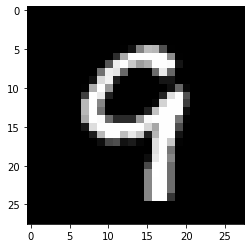

In [11]:
a=150
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)
#b_i, (sample_data, sample_targets) = next(test_samples)
plt.imshow(sample_data[a][0],cmap='gray',interpolation='none')


In [12]:
sample_data = sample_data.to("cuda")
print(f"Model prediction is: {model(sample_data).data.max(1)[1][a]}")

Model prediction is: 9
